# 1- Setup 


## 1-1 Install Dependencies

In [1]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 1-2 Import Dependencies

In [1]:
# import tensorflow dependencies
import cv2
import random
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import glob

In [7]:
# The reason behind importing plt is the function plt.imshow() that 
# us to visualize an image , we will need it with facial recognition

In [ ]:
# Let's mention that we will try to reconstruct  a model found the 
# "Siamese Neural Networks for One-shot Image Recognition" research paper

In [2]:
# importing tensorflow dependencies 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer , Conv2D , Dense , MaxPooling2D , Input , Flatten
import tensorflow as tf
# importing metrics
from tensorflow.keras.metrics import Precision, Recall

2023-07-05 14:41:41.567313: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 14:41:41.907103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 14:41:41.910533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 14:41:43.516339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [52]:
# The Model will be fed an input wich represent a vector composed of 2 images
# one is the image we want to identify, and one is the target we want to
# identify the image to. For exemple we take messi we re gonna take a 
# 19 yo messi and verify it to a 35 yo messi 

# Model(inputs= [inputimage , verificationimage] , outputs = [1,0] )

## 1-3 Create Folder Structures

In [3]:
# setting up paths

# sub-network within the Siamese neural network that processes another image of person whome we need to identify
Pos_path = os.path.join('data','positive')

# sub-network within the Siamese neural network that processes different image of person whome we need to identify
Neg_path = os.path.join('data','negative')

# sub-network within the Siamese neural network that processes image of person whome we need to identify
Anc_path = os.path.join('data','anchor')

In [ ]:
# create the directories

os.makedirs(Pos_path)
os.makedirs(Neg_path)
os.makedirs(Anc_path)

# 2- Collect Positives and Anchors

## 2-1 Untar footballers dataset

In [7]:
# Uncompress the tar file Fz labeled faces in the wild dataset

!tar -xf footballers.tgz

In [8]:
for directory in os.listdir('footballers'):
    for file in os.listdir(os.path.join('footballers', directory)):
        Ex_path = os.path.join('footballers', directory, file)
        New_path = os.path.join(Neg_path, file)
        os.replace(Ex_path, New_path)

## 2-2 Collect Positive and Anchor classes

We collected Anchor and Positive pictures from a messi dataset
We divided the same dataset to two different and equal parts
First part was given to Anchor
Second part was given to Positive

# 3- Load and Preprocess images

## 3-1 Get Image Directories and preprocess/scale/resize them


In [4]:
# Example parameters
image_size = (224, 224)

def preprocess_image(image_path):
    # Read in image from file path
    byte_img = tf.io.read_file(image_path)
    # Load in the image 
    image = tf.image.decode_png(byte_img, channels=3)
    
    # Preprocessing steps - resizing the image to be 105x105x3
    image = tf.image.resize(image, (105, 105))
    # Scale image to be between 0 and 1 
    image = image / 255.0
    
    # Return image
    return image


# Get file paths using glob
file_pattern = os.path.join(Anc_path, '*.png')
file_list = glob.glob(file_pattern)

# Create anchor dataset
anchor = tf.data.Dataset.from_tensor_slices(file_list[:191])
anchor = anchor.map(preprocess_image)


# Get file paths using glob
file_pattern = os.path.join(Neg_path, '*.png')
file_list = glob.glob(file_pattern)

# Create negative dataset
negative = tf.data.Dataset.from_tensor_slices(file_list[:191])
negative = negative.map(preprocess_image)


# Get file paths using glob
file_pattern = os.path.join(Pos_path, '*.png')
file_list = glob.glob(file_pattern)

# Create positive dataset
positive = tf.data.Dataset.from_tensor_slices(file_list[:191])
positive = positive.map(preprocess_image)

2023-07-05 14:41:51.912476: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


2023-07-05 14:41:54.046607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [191]
	 [[{{node Placeholder/_0}}]]
2023-07-05 14:41:55.236051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [191]
	 [[{{node Placeholder/_0}}]]
2023-07-05 14:41:55.451478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [191]
	

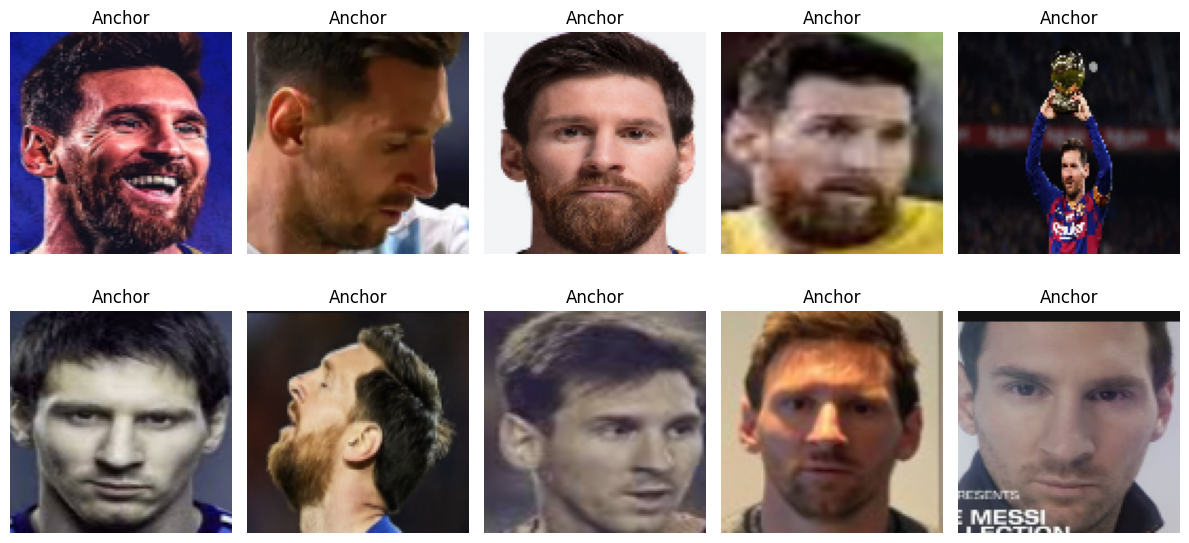

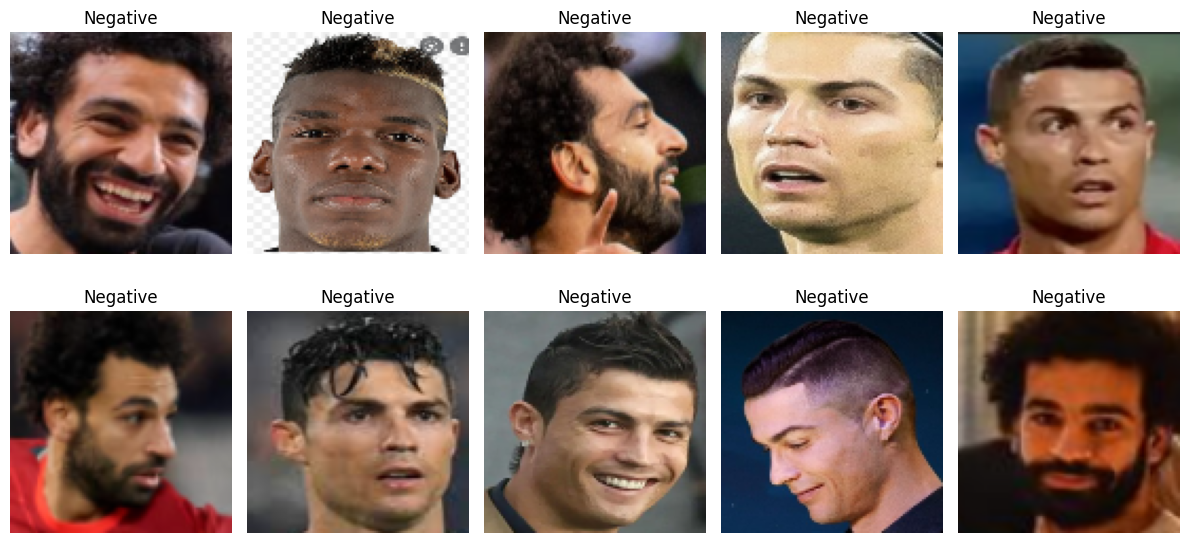

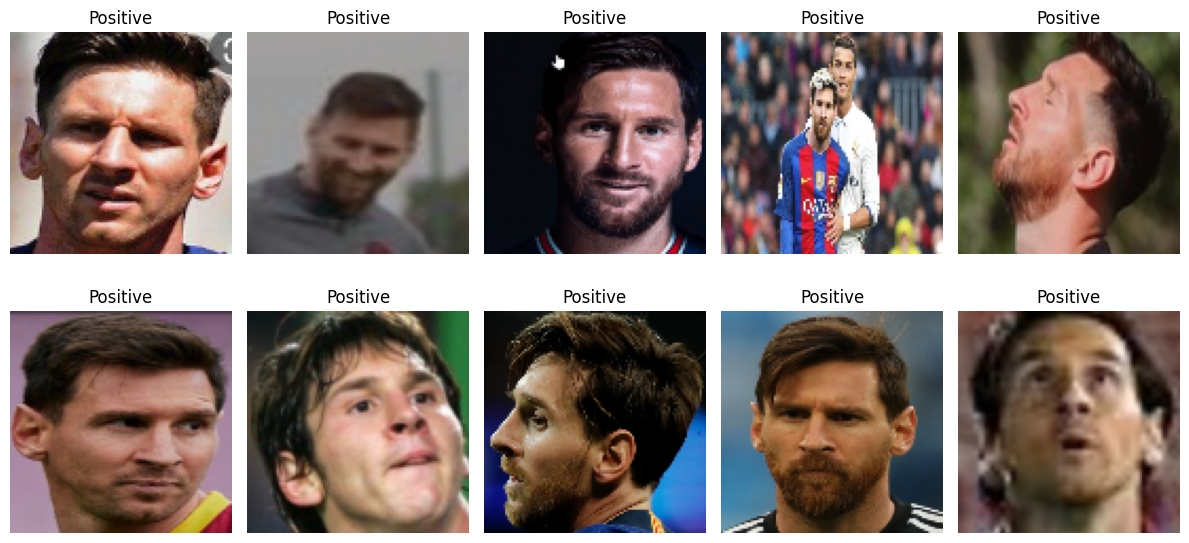

In [5]:
# Function to display a grid of images from each repository
# To make sure that our previous block was well done executed
# as you can see it is accurate 

def display_images(images, labels):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(labels[i])
    plt.tight_layout()
    plt.show()

# Convert datasets to lists


anchor_list = list(anchor.as_numpy_iterator())
negative_list = list(negative.as_numpy_iterator())
positive_list = list(positive.as_numpy_iterator())

# Randomly select 10 images from each directory for display


random.shuffle(anchor_list)
random.shuffle(negative_list)
random.shuffle(positive_list)

display_images(anchor_list[:10], ["Anchor"] * 10)
display_images(negative_list[:10], ["Negative"] * 10)
display_images(positive_list[:10], ["Positive"] * 10)


## 3-2 Create a labeled dataset

 (anchor, positive) => 1,1,1,1,1    
 
 (anchor, negative) => 0,0,0,0,0

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [7]:
# we generate a random sample using as_numpy_iterator

samples = data.as_numpy_iterator()

# then we assign to example a sample 

example = samples.next()

# the sample as shown is formed of 3 parts, first is an array of 3 arrays
# RGB, second is similar, means they re boths pictures, and third is a label
# 1 if images are similar 0 if not
example

2023-07-05 14:42:04.206443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype float and shape [191]
	 [[{{node Placeholder/_6}}]]


(array([[[0.92941177, 0.8117647 , 0.33777776],
         [0.93186927, 0.8093072 , 0.3349692 ],
         [0.93319017, 0.8096421 , 0.33004668],
         ...,
         [0.92941177, 0.8039216 , 0.32156864],
         [0.92941177, 0.8039216 , 0.32156864],
         [0.92941177, 0.8039216 , 0.32156864]],
 
        [[0.9286275 , 0.8109804 , 0.34588233],
         [0.92915404, 0.8109804 , 0.34061623],
         [0.93154055, 0.80956113, 0.3344911 ],
         ...,
         [0.92941177, 0.8039216 , 0.32156864],
         [0.92941177, 0.8039216 , 0.32156864],
         [0.92941177, 0.8039216 , 0.32156864]],
 
        [[0.9267974 , 0.80784315, 0.3503268 ],
         [0.9294304 , 0.80784315, 0.3450607 ],
         [0.93367565, 0.80784315, 0.33834422],
         ...,
         [0.92941177, 0.8039216 , 0.32156864],
         [0.92941177, 0.8039216 , 0.32156864],
         [0.92941177, 0.8039216 , 0.32156864]],
 
        ...,
 
        [[0.92941177, 0.8117647 , 0.33333334],
         [0.92941177, 0.8117647 , 0.33333

## 3-3 Train and Test Partition

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return(input_img, validation_img, label)

In [9]:
# we re using * args because we obtained exemple wich is a tuple of 2 imgs
# and a coincidence label

res = preprocess_twin(*example)

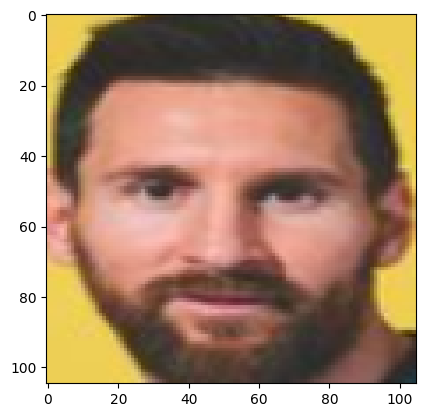

In [10]:
# when we plot res[0] we will get anchor image of messi

plt.imshow(res[0])

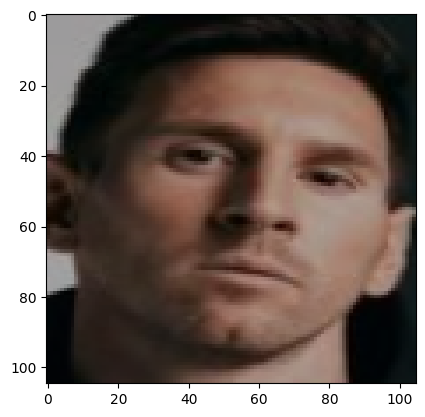

In [11]:
# when we plot res[1] we will get positive image (another) of messi

plt.imshow(res[1])

In [12]:
# when we exe res[2] we will get a positive label, means we've got a match

res[2]

1.0

In [13]:
# Build dataloader pipeline
# Apply preprocess_twin on all dataset
data = data.map(preprocess_twin)

# Caching improves performance by storing the 
# elements in memory or on disk

data = data.cache()

# shuffles the elements in the dataset data using a buffer size of 1024
# creating a randomized order of the data.

data = data.shuffle(buffer_size=1024)

In [14]:
# Training partition
# Taking 70% of the dataset as training set

train_data = data.take(round(len(data)*.7))

# Creating batches of 16 elements, for efficient processing of the data

train_data = train_data.batch(16)

# Prefetching 8 batches of data to construct a pipeline and minimize the
# processing time by overlapping data preprocessing and model execution

train_data = train_data.prefetch(8)

In [15]:
# Testing partition
# Utilizing data.skip to exclude the 70% of the data used for training, 
# and then applying data.take to ensure a 30% portion specifically for
# testing you create a separate testing partition.

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))

# Same again with batch size and prefetching

test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4- Model Architecture

## 4-1 Embedding Layer

In [17]:
def make_embedding(): 
    """
    Constructs an embedding model based on the architecture from the Siamese Neural Network for one-shot image recognition research paper.

    Returns:
    - A Keras Model object representing the embedding model.
    
    The architecture of the model consists of convolutional and dense layers to create an embedding representation of input images. It follows the design presented in the Siamese Neural Network for one-shot image recognition research paper. The model takes an input image tensor of shape (105, 105, 3) and outputs an embedding vector of size 4096.

    The model architecture:
    - Three blocks of Conv2D and MaxPooling2D layers for feature extraction.
    - A final embedding block with Conv2D layer.
    - A Flatten layer to reshape the feature maps.
    - A Dense layer with sigmoid activation for generating the embedding representation.

    This embedding model can be used for various tasks such as image similarity, clustering, or classification.

    Reference:
    Siamese Neural Networks for One-shot Image Recognition by Gregory Koch, Richard Zemel, Ruslan Salakhutdinov. Published in 2015.

    """
    
    # Define the input layer
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    # First Convolutional layer with 64 filters and ReLU activation, 
    # followed by Max Pooling layer with 2x2 window and 'same' padding

    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    # Second Convolutional layer with 128 filters and ReLU activation, 
    # followed by Max Pooling layer with 2x2 window and 'same' padding
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    # Third Convolutional layer with 128 filters and ReLU activation, 
    # followed by Max Pooling layer with 2x2 window and 'same' padding
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    # Fourth Convolutional layer with 256 filters and ReLU activation
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    # Flatten layer to convert 3D feature maps into 1D vector
    f1 = Flatten()(c4)
    # Fully connected Dense layer with 4096 units and sigmoid activation
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    # Returns the embedding model
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [18]:
embedding = make_embedding()

# Print the model summary

embedding.summary()

2023-07-05 14:42:27.360448: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2023-07-05 14:42:27.524963: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2023-07-05 14:42:27.706268: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## 4-2 Distance Layer

In [19]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # This is the functin that computes similarity calculation between pictures
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


In [20]:
# we define the an object of the new class and we check it 

l1 = L1Dist()
l1

## 4-3 Siamese Model

In [21]:
def make_siamese_model():
    
    """
    Creates a Siamese network model for one-shot image recognition.

    This function constructs a Siamese network model with an input pipeline for anchor and validation images,
    a distance calculation layer based on L1 distance, and a classification layer.

    Returns:
        A `Model` object representing the Siamese network model.

    """
    
    # Anchor image input in the network
    
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network
    
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    # Create an instance of the L1Dist layer
    
    siamese_layer = L1Dist()
    
    # Rename the siamese layer for clarity
    
    siamese_layer._name = 'distance'
    
    # Calculate the distances between the embeddings of anchor and validation images
    
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    # Pass the distances through a dense layer with sigmoid activation
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    # Create the Siamese network model
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [22]:
siamese_model = make_siamese_model()

In [23]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5- Training Phase

## 5-1 Loss function and Optimizer

In [24]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [25]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5-2 Checkpoints


In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5-3 Train Step Function

In [27]:
# used only to optimize the perf of the func by converting it to TF graph
@tf.function 
def train_step(batch):
    
    """
    Performs a single training step for the siamese model.

    Args:
        batch: A batch of training data containing anchor image, positive/negative image, and label.

    Returns:
        loss: The calculated loss value for the batch.
    """
    
    # The tf.GradientTape() context manager records the operations executed within its scope, storing them in a tape 
    # for later use during backpropagation to compute gradients with respect to the recorded operations. This allows 
    # for efficient differentiation and gradient calculation.
    
    with tf.GradientTape() as tape:   
        
        # Extract anchor and positive/negative images
        
        X = batch[:2]
        
        # extract labels
        
        y = batch[2]
        
        # Forward pass in the siamese model
        
        yhat = siamese_model(X, training=True)
        
        # Calculate binary cross-entropy loss 
        
        loss = binary_cross_loss(y, yhat)
        
    print(loss)
        
    # Calculate gradients of the loss with respect to the variables
    
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Classical update of weights like in DNN
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5-4 Training loop

In [28]:
# care there is a diff betweeen capital EPOCHS and lower epochs one is the
# variable name the other is an iteration variable

def train(data, EPOCHS):
    """
    Trains the Siamese network using the provided data for a specified number of epochs.

    Args:
        data (tf.data.Dataset): The dataset containing the training samples.
        EPOCHS (int): The number of training epochs.

    Returns:
        None
    """
    
    # Loop through epochs
    
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        
        # creating tf progress bar similar to taqadom tqdm in python
        
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch in training data
        
        for idx, batch in enumerate(data):
            
            # Run train step here, single step by single step
            
            train_step(batch)
            
            # Then update the progbar to show completion of current batch
            
            progbar.update(idx+1)
        
        # Save checkpoints
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5-5 Train Model

In [36]:
# we determine number of EPOCHS

EPOCHS = 30

In [44]:
# Apply the train function

train(train_data, EPOCHS)


 Epoch 1/30
17/17 [==============================] - 389s 23s/step

 Epoch 2/30
17/17 [==============================] - 380s 22s/step

 Epoch 3/30
17/17 [==============================] - 380s 22s/step

 Epoch 4/30
17/17 [==============================] - 379s 22s/step

 Epoch 5/30
17/17 [==============================] - 414s 24s/step

 Epoch 6/30
17/17 [==============================] - 420s 25s/step

 Epoch 7/30
17/17 [==============================] - 406s 24s/step

 Epoch 8/30
17/17 [==============================] - 409s 24s/step

 Epoch 9/30
17/17 [==============================] - 384s 23s/step

 Epoch 10/30
17/17 [==============================] - 382s 22s/step

 Epoch 11/30
17/17 [==============================] - 381s 22s/step

 Epoch 12/30
17/17 [==============================] - 386s 23s/step

 Epoch 13/30
17/17 [==============================] - 381s 22s/step

 Epoch 14/30
17/17 [==============================] - 380s 22s/step

 Epoch 15/30
17/17 [======================

# 6- Evaluation of the model

## 6-1 Metrics and Prediction

In [29]:
# Extract a batch of test data for evaluation

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

2023-07-05 14:42:55.607732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype float and shape [191]
	 [[{{node Placeholder/_15}}]]
2023-07-05 14:42:55.608550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype string and shape [191]
	 [[{{node Placeholder/_3}}]]
2023-07-05 14:42:55.696622: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38158848 exceeds 10% of free system memory.


In [45]:
# Perform predictions using the Siamese model on the test data batch

y_hat = siamese_model.predict([test_input, test_val])

# The displayed array is an array of probabilities that a sample belongs 
# to the pos class

# In y_hat if the value is so small means converging to 0 that means that we got a negative sample, if we got a 1
# or  a value close to 1 that means its a positive sample

y_hat

1/1 [==============================] - 1s 1s/step


array([[0.02604367],
       [0.04669895],
       [0.507009  ],
       [0.69781965],
       [0.09235792],
       [0.02379143],
       [0.9486905 ],
       [0.00166554],
       [0.87690884],
       [0.01995543],
       [0.71614325],
       [0.06190543],
       [0.99142337],
       [0.04402001],
       [0.0419736 ],
       [0.01805192]], dtype=float32)

In [47]:
# Post processing the results and applying a threshold of 0.5 in that way we convert them to classification output

[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]

In [48]:
# True labels values of the test

y_true

array([0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
      dtype=float32)

## 6-2 Compute Metrics

In [49]:
# Creating a metric object recall

r = Recall()

# Updating the recall value using y_hat  and y_true

r.update_state(y_true, y_hat)

# Return Recall Result

r.result().numpy()

1.0

In [50]:
# Creating a metric object precision

p = Precision()

# Same logic as recall

p.update_state(y_true, y_hat)

# Return Recall Result

p.result().numpy()

1.0

## 6-3 Visualization

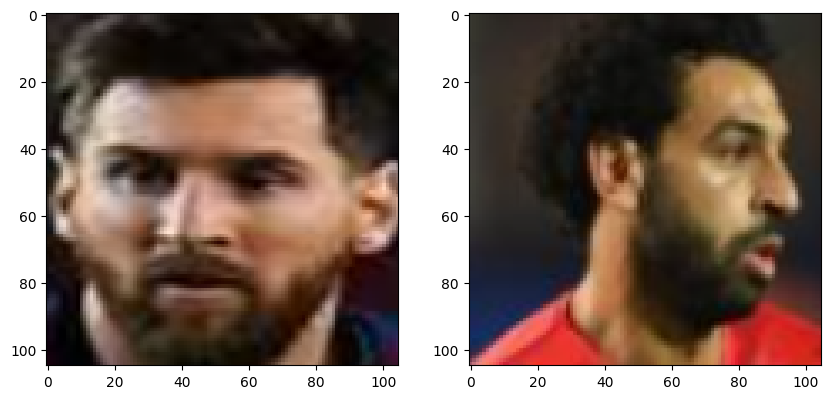

In [51]:
# Check the label array, this case is a negative case ( non matching example)

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

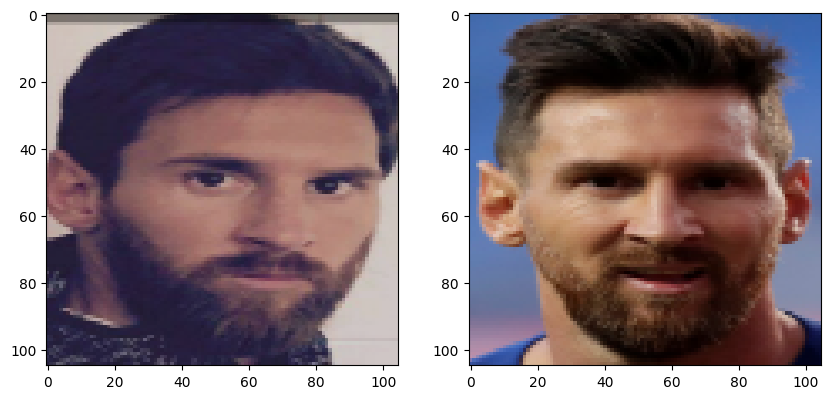

In [52]:
# Check the label array, this case is a positive case (matching example)

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

# 7- Save Model

In [53]:
# Save weights

siamese_model.save('siamesemodel.h5')

In [30]:
# The function load_model allows us to load any model saved using model.save
# It allows us to load the pre-trained model with all his weights acquired from the 30 epochs

model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [31]:
# Make predictions with reloaded model to make sure it's working

model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[9.69806671e-01],
       [9.31708336e-01],
       [9.90430355e-01],
       [1.50712922e-01],
       [6.89910026e-04],
       [8.44604790e-01],
       [9.93983209e-01],
       [4.66989502e-02],
       [7.16143250e-01],
       [6.20192103e-03],
       [9.81624544e-01],
       [9.99733269e-01],
       [1.17889024e-01],
       [3.72522831e-01],
       [9.97971177e-01],
       [8.74362588e-01]], dtype=float32)

In [32]:
# View reloaded model summary, PS : they will be no change

model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8- Real time application of the model

## 8-1 Verification function from folder

In [33]:
path = r'application_data\verification_images'

In [34]:
# To list the 50 messi pictures we re using for the verification

os.listdir(os.path.join('application_data', 'verification_images'))

['opera_6fUqS8p0E0.png',
 'opera_goxD9frERa.png',
 'opera_IsALRE0fnZ.png',
 'forbes-highest-paid-athletes-2019-00.png',
 'opera_Ell40ixsUJ.png',
 'opera_9fbo8bqbe7.png',
 'opera_GY8zHpDssH.png',
 'opera_8fUaljSqIZ.png',
 'opera_GCqmI4W61I.png',
 'opera_2sVEBYqfjh.png',
 'opera_4wIxpI787v.png',
 'opera_AkwFKkRW9H.png',
 'opera_JAs8YPuZUr.png',
 'opera_01mAWAPLpw.png',
 'opera_4ZZDtcd5S1.png',
 '8e28dca199d2c529e710f2fc7550fc85.png',
 'opera_2ueHOkC0T1.png',
 'opera_B66RlgettU.png',
 'opera_aeRLdNLaix.png',
 'opera_FjEKS3AHzE.png',
 'opera_9MeexMw8Wr.png',
 'opera_2LX5db8I2E.png',
 'lionel-messi-1583899230.png',
 'opera_5XVqtJd8Dt.png',
 'opera_Ib3bQosHmT.png',
 'opera_deqyFHEwmR.png',
 'opera_AxpC20YArD.png',
 'opera_FHjOi7zwxa.png',
 'opera_Att6QS9U8P.png',
 'opera_epDqNcXIEN.png',
 '960.png',
 'opera_96RaZlcOAW.png',
 'lionel-messi-barcelona_s4mt4mvtjyy41gz5noeslzqjt.png',
 'opera_ac1X43hlZW.png',
 'opera_1DAtUGQZmM.png',
 '27243622-0-image-m-13_1586991155251.png',
 '5bd946a6cdbadfc41

In [35]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess_image(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess_image(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8-2 Real time verification using Opencv and cam

In [1]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        # Save input image to application_data/input_image folder 
        
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Run verification
        
        results, verified = verify(model, 0.6, 0.6)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


NameError: name 'cv2' is not defined